In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Lambda, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

In [3]:
tf.__version__

'2.17.1'

In [4]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/palm-recognizition/data/aug'

In [5]:
img_width, img_height = 128, 128
input_shape = (img_width, img_height, 1)

In [6]:
# Fungsi untuk memuat gambar dan resize
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Membaca gambar grayscale
    img = cv2.resize(img, (img_width, img_height))  # Resize gambar
    img = img.astype('float32') / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=-1)  # Menambahkan dimensi channel
    return img


In [7]:
def load_and_preprocess_data(data_dir):
    X = []
    y = []

    # Baca data dari direktori aug
    for person_dir in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person_dir)
        if os.path.isdir(person_path):
            # Check if the last part of the directory name is numeric before converting to int
            if person_dir.split('_')[-1].isdigit():
                person_id = int(person_dir.split('_')[-1])
                image_paths = glob(os.path.join(person_path, '*.jpg'))

                for image_path in image_paths:
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    image = cv2.resize(image, (128, 128))
                    image = image / 255.0  # Normalisasi ke rentang 0-1
                    X.append(image)
                    y.append(person_id)

    return np.array(X), np.array(y)

In [8]:
# Baca dan preprocess data
X, y = load_and_preprocess_data(data_dir)
print(f"Jumlah data: {len(X)}")
print(f"Ukuran input: {X.shape[1:]}")

Jumlah data: 640
Ukuran input: (128, 128)


In [9]:
def create_pairs(directory):
    pairs = []
    labels = []
    people = os.listdir(directory)

    for person in people:
        person_path = os.path.join(directory, person)
        images = os.listdir(person_path)
        for i in range(len(images)):
            for j in range(i + 1, len(images)):
                img1 = load_image(os.path.join(person_path, images[i]))
                img2 = load_image(os.path.join(person_path, images[j]))
                pairs.append([img1, img2])
                labels.append(1)  # Pair positif (gambar dari orang yang sama)

        for other_person in [p for p in people if p != person]:
            other_path = os.path.join(directory, other_person)

            # Check if the directory is not empty
            other_images = os.listdir(other_path)
            if other_images:  # Proceed only if there are files in the directory
                other_image = load_image(os.path.join(other_path, other_images[0]))
                pairs.append([img1, other_image])
                labels.append(0)  # Pair negatif (gambar dari orang berbeda)

    return np.array(pairs), np.array(labels)

In [10]:
# Load pasangan data
pairs, labels = create_pairs(data_dir)

# Split data menjadi training dan validation (contoh 80-20 split)
from sklearn.model_selection import train_test_split
(pairs_train, pairs_val, labels_train, labels_val) = train_test_split(pairs, labels, test_size=0.2, random_state=42)

In [11]:
print('Train pairs shape:', pairs_train.shape)
print ('Test pairs shape:', pairs_val.shape)
print ('Train labels shape:', labels_train.shape)
print ('Test labels shape:', labels_val.shape)

Train pairs shape: (5657, 2, 128, 128, 1)
Test pairs shape: (1415, 2, 128, 128, 1)
Train labels shape: (5657,)
Test labels shape: (1415,)


In [12]:
labels_train = np.array(labels_train).astype(np.float32)
labels_val = np.array(labels_val).astype(np.float32)


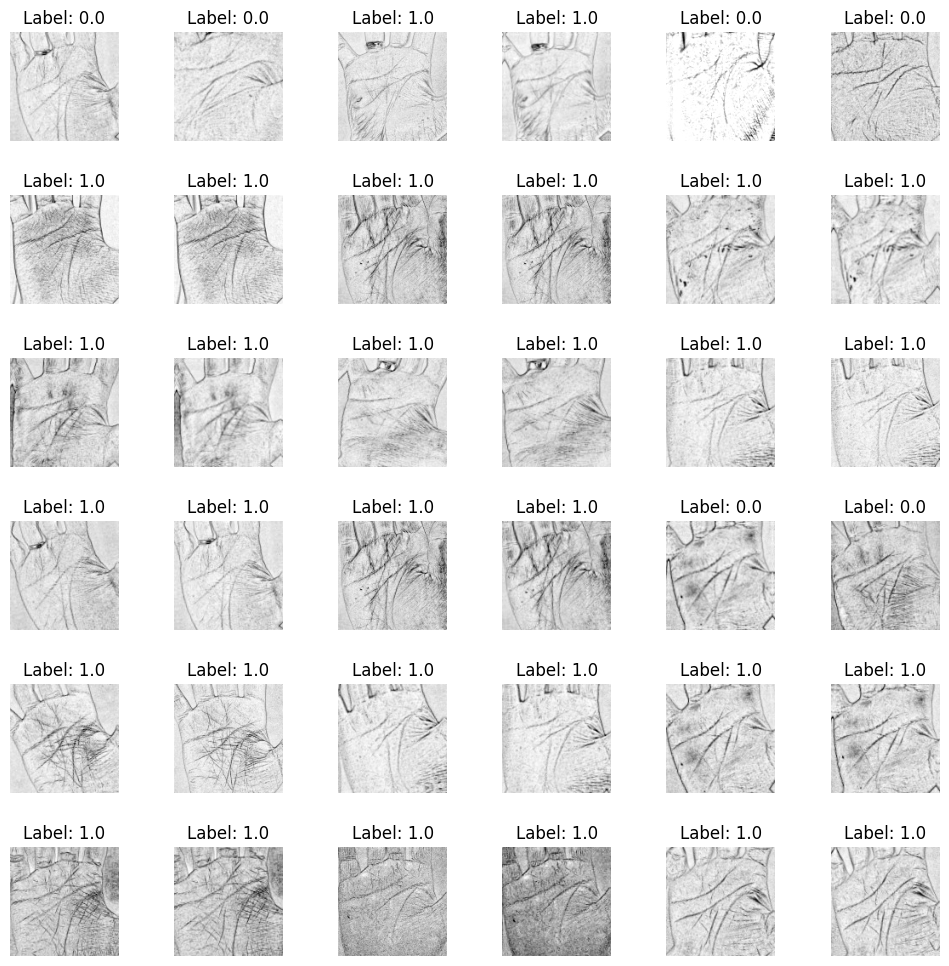

In [13]:
# Menampilkan grid pasangan gambar (pairs) dan label untuk visualisasi
import matplotlib.pyplot as plt

# Membuat grid untuk visualisasi pasangan gambar
fig, ax = plt.subplots(6, 6, figsize=(12, 12))  # 6x6 grid (12 gambar pairs)
counter = 0

for i in range(6):  # Baris grid
    for j in range(0, 6, 2):  # Kolom grid (2 gambar per pasangan)
        # Mengambil pasangan gambar dan label
        img1 = pairs_train[counter][0]  # Gambar pertama dalam pasangan
        img2 = pairs_train[counter][1]  # Gambar kedua dalam pasangan
        label = labels_train[counter]  # Label pasangan

        # Menampilkan gambar pertama
        # Reshape img1 to (128, 128) before displaying it
        ax[i, j].imshow(img1.reshape(128, 128), cmap='gray')  # Gambar grayscale
        ax[i, j].set_title(f'Label: {label}')
        ax[i, j].axis('off')  # Sembunyikan axis

        # Menampilkan gambar kedua
        # Reshape img2 to (128, 128) before displaying it
        ax[i, j+1].imshow(img2.reshape(128, 128), cmap='gray')  # Gambar grayscale
        ax[i, j+1].set_title(f'Label: {label}')
        ax[i, j+1].axis('off')  # Sembunyikan axis

        counter += 1  # Beralih ke pasangan berikutnya

# Menyesuaikan jarak antar subplot
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def contrastive_loss(y_true, y_pred, margin=1.0):
    """Modified contrastive loss with scaling"""
    # Scale down predictions to prevent explosion
    y_pred = y_pred / 100.0  # Scaling factor

    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))

    # Add small epsilon to prevent numerical instability
    return tf.reduce_mean(
        y_true * square_pred + (1 - y_true) * margin_square + tf.keras.backend.epsilon()
    )
# Custom loss layer
class ContrastiveLoss(tf.keras.layers.Layer):
    def __init__(self, margin=1.0, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin

    def call(self, y_true, y_pred):
        return contrastive_loss(y_true, y_pred, self.margin)

In [15]:
# def build_siamese_model(input_shape=(128, 128, 1)):
#     input = Input(shape=input_shape)
#     x = Conv2D(64, (10, 10), activation='relu')(input)
#     x = MaxPooling2D()(x)
#     x = Conv2D(128, (7, 7), activation='relu')(x)
#     x = MaxPooling2D()(x)
#     x = Conv2D(128, (4, 4), activation='relu')(x)
#     x = MaxPooling2D()(x)
#     x = Conv2D(256, (4, 4), activation='relu')(x)
#     x = Flatten()(x)
#     x = Dense(4096, activation='sigmoid')(x)
#     model = Model(input, x)

#     return model

def build_siamese_model(input_shape=(128, 128, 1)):
    """Build a memory-efficient siamese model that maintains learning capacity"""
    input = Input(shape=input_shape)

    # First convolutional block
    x = Conv2D(64, (10, 10), activation='relu')(input)
    x = MaxPooling2D()(x)

    # Second convolutional block
    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D()(x)

    # Third convolutional block
    x = Conv2D(128, (4, 4), activation='relu')(x)
    x = MaxPooling2D()(x)

    # Fourth convolutional block
    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = MaxPooling2D()(x)  # Added extra MaxPooling to reduce dimensions

    x = Flatten()(x)

    # Replace single large Dense layer with smaller sequential Dense layers
    x = Dense(4096, activation='relu', name='dense1')(x)

    model = Model(input, x)
    return model

In [16]:
# def build_complete_model(input_shape=(128, 128, 1)):
#     """Build the complete siamese network with pre-trained CNN"""
#     base_network = build_siamese_model(input_shape)

#     input_a = Input(shape=input_shape)
#     input_b = Input(shape=input_shape)

#     processed_a = base_network(input_a)
#     processed_b = base_network(input_b)

#     distance = Lambda(
#       lambda embeddings: tf.abs(embeddings[0] - embeddings[1]),
#       output_shape=lambda input_shapes: input_shapes[0]
#      )([processed_a, processed_b])

#     prediction = Dense(1, activation='sigmoid')(distance)
#     model = Model([input_a, input_b], prediction)

#     return model

def build_siamese_network():
    base_network = build_siamese_model()

    input_a = Input(shape=(128, 128, 1))
    input_b = Input(shape=(128, 128, 1))

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(euclidean_distance)([processed_a, processed_b])

    model = Model(inputs=[input_a, input_b], outputs=distance)
    return model

In [17]:
print(pairs_train[:, 0].shape)  # Dimensi input A
print(pairs_train[:, 1].shape)  # Dimensi input B
print(labels_train.shape)       # Dimensi label


(5657, 128, 128, 1)
(5657, 128, 128, 1)
(5657,)


In [18]:
model = build_siamese_network()
model.compile(loss=contrastive_loss, optimizer=Adam(0.0001), metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 4096)           │     17,976,128 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,976,128 (68.57 MB)

 Trainable params: 17,976,128 (68.57 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Callback untuk early stopping jika val_accuracy tidak meningkat
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Callback untuk mengurangi learning rate jika val_loss stagnan
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [20]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')

        # Cek apakah akurasi validasi lebih dari 99% dan loss validasi lebih kecil dari 0.05
        if val_accuracy > 0.99 and val_loss < 0.05:
            print(f"\nEpoch {epoch + 1}: Validation accuracy > 99% and validation loss < 0.05, stopping training.")
            self.model.stop_training = True

callbacks = [CustomCallback()]

In [21]:
# Prepare the data
X_train = [pairs_train[:, 0], pairs_train[:, 1]]
X_test = [pairs_val[:, 0], pairs_val[:, 1]]
y_train = labels_train.astype('float32')
y_test = labels_val.astype('float32')


In [25]:
# Training model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=2,
    callbacks=[reduce_lr, callbacks]
)

Epoch 1/2
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.7950 - loss: 0.0832 - val_accuracy: 0.8141 - val_loss: 0.0551 - learning_rate: 1.0000e-04
Epoch 2/2
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.7559 - loss: 0.0691 - val_accuracy: 0.8198 - val_loss: 0.0728 - learning_rate: 1.0000e-04


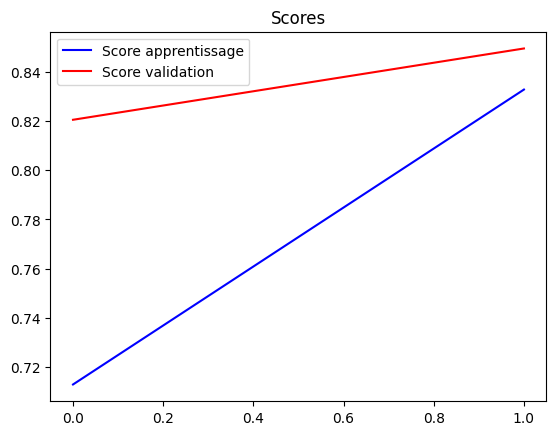

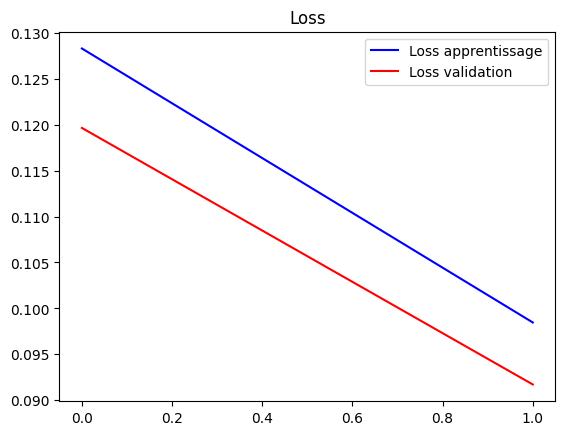

In [23]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_scores(history)
plot_loss(history)

In [24]:
model_json = model.to_json()
#.json is the architecture
with open("palm_print_siamese_model.json", "w") as json_file:
    json_file.write(model_json)
#.h5 is the weights of the model
model.save('palm_print_siamese_model.h5')

model.load_weights('palm_print_siamese_model.h5')